<a href="https://colab.research.google.com/github/hoky1227/Transformer_based-recommendation/blob/main/Transformer_Korean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gdrive  연동

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/'

Mounted at /content/drive


# Import Modules

In [ ]:
!pip install konlpy # 한국어 Tokenizer

In [ ]:
from dateutil.parser import parse
import tqdm
import tensorflow_datasets as tfds
import tensorflow as tf
import re

import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import math
from numpy.linalg import norm
from konlpy.tag import Kkma
kkma = Kkma()
from konlpy.tag import Okt
okt = Okt()
import warnings 

warnings.filterwarnings('ignore')

#재현성을 위해 seed 고정

np.random.seed(2021)
tf.random.set_seed(2021)

# Data 전처리

In [ ]:
df = pd.read_excel(path + "transformer_UB.xlsx")
print(df.isnull().sum())
df.dropna(inplace=True)
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
df

,거래번호,거래일자,거래시간,고객번호,상품명,구분
0,061R216791404802,20210302,18,1030910,Americano / Tall외 1건,울산페이
1,061R214106002408,20210302,11,1030910,Americano / Tall외 2건,울산페이
2,062R213236207516,20210303,8,1030910,Caffe Mocha / Tall외 1건,울산페이
3,062R213236807497,20210303,9,1025745,Americano / Tall외 1건,울산페이
4,061R216769704492,20210302,18,1030910,Americano / Tall외 1건,울산페이
...,...,...,...,...,...,...
13645,280R204467323876,20201006,122449,719672,[한예지] 볼륨앤소프트 3겹 화장지 20m 30롤 3팩,유비페이(구)
13646,280R204477123830,20201006,122628,942118,약제비,유비페이(구)
13647,280R205282523848,20201006,144042,703839,[2020년 햇]강화순무 4kg + 강화순무물김치 3kg / 총 7kg,유비페이(구)
13648,280R205324523933,20201006,144908,1063907,NaN,유비페이(구)


In [ ]:
df.drop(['구분'],axis=1, inplace=True)
df.head()

,거래번호,거래일자,거래시간,고객번호,상품명
0,061R216791404802,20210302,18,1030910,Americano / Tall외 1건
1,061R214106002408,20210302,11,1030910,Americano / Tall외 2건
2,062R213236207516,20210303,8,1030910,Caffe Mocha / Tall외 1건
3,062R213236807497,20210303,9,1025745,Americano / Tall외 1건
4,061R216769704492,20210302,18,1030910,Americano / Tall외 1건


In [ ]:
detail = df['상품명'].unique() # Jaccard 유사도 검사에 필요
len(detail)

1982

In [ ]:
def sortdf(data, column):
    data.sort_values(column, inplace=True)
    data.reset_index(inplace=True)
    data.pop('index')
    return data

In [ ]:
sortdf(df, ['고객번호', '거래일자', '거래시간'])

,거래번호,거래일자,거래시간,고객번호,상품명
0,122R203988815073,20200501,110500,36,우편물
1,203R204371664285,20200721,120902,36,더블더블 / 감자튀김 딥치즈 업그레이드 세트
2,204R204556964772,20200722,123940,36,꿀유자차 / 아이스
3,205R204563565281,20200723,124049,36,바닐라라떼 / 아이스
4,206R204522965902,20200724,123402,36,바닐라라떼 / 아이스
...,...,...,...,...,...
12420,070R214128821970,20210311,11,1987728,아메리카노 / ICE
12421,076R214076933731,20210317,11,1996381,[Best] 제주 흑돼지 돈까스샌드위치
12422,076R215430534237,20210317,15,1996381,[Bset] 프레즐빠다
12423,076R215684034355,20210317,15,1996646,에그모닝


In [ ]:
df.drop(['거래번호', '거래일자', '거래시간'],axis=1, inplace=True)
df.head()

,고객번호,상품명
0,36,우편물
1,36,더블더블 / 감자튀김 딥치즈 업그레이드 세트
2,36,꿀유자차 / 아이스
3,36,바닐라라떼 / 아이스
4,36,바닐라라떼 / 아이스


In [ ]:
# 거래건수 1건인 유저 제외
user = df['고객번호'].unique()

for v in user:
    a = df[df['고객번호'] == v]
    if len(a) < 2:
        idx = a.index
        df.drop(idx, inplace=True)
df

,고객번호,상품명
0,36,우편물
1,36,더블더블 / 감자튀김 딥치즈 업그레이드 세트
2,36,꿀유자차 / 아이스
3,36,바닐라라떼 / 아이스
4,36,바닐라라떼 / 아이스
...,...,...
12420,1987728,아메리카노 / ICE
12421,1996381,[Best] 제주 흑돼지 돈까스샌드위치
12422,1996381,[Bset] 프레즐빠다
12423,1996646,에그모닝


## Customer 기준 history

In [ ]:
df2 = pd.DataFrame(columns=df.columns)
values = df['고객번호'].value_counts().index.sort_values()

for i, v in enumerate(values):
    df2.loc[i] = (v, '&&'.join(df[df['고객번호'] == v]['상품명']))
df2

,고객번호,상품명
0,36,우편물&&더블더블 / 감자튀김 딥치즈 업그레이드 세트&&꿀유자차 / 아이스&&바닐라...
1,17492,납기내금액&&납기내금액&&납기내금액&&납기내금액&&납기내금액&&납기내금액&&납기내금...
2,26661,무료배달&&무료배달&&베이컨 치즈버거 / 일반세트(버거+음료+감자튀김)&&무료배달&...
3,27462,"컬쳐캐쉬1건&&컬쳐캐쉬1건&&아메리카노(일반) / 아이스,킹&&떡볶이&&더블더블 /..."
4,27478,납기내금액&&납기내금액&&임성근손질민물장어 12팩+소스10봉&&납기내금액&&아메리카...
...,...,...
3407,1987446,일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건&&일벌세트 / 약간 덜매운...
3408,1987625,(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건&&(2마리) 코다리매콤명태찜 /...
3409,1987728,리얼초코자바칩프라페 / 휘핑 반만올리기외 1건&&아메리카노 / HOT&&아메리카노 ...
3410,1996381,[Best] 제주 흑돼지 돈까스샌드위치&&[Bset] 프레즐빠다


In [ ]:
ds_customer = df2.copy()
ds_customer

## 4 + 1로 전처리

In [ ]:
df_series = df2['상품명'].str.split('&&')
df_series[:2]

0    [우편물, 더블더블 / 감자튀김 딥치즈 업그레이드 세트, 꿀유자차 / 아이스, 바닐...
1    [납기내금액, 납기내금액, 납기내금액, 납기내금액, 납기내금액, 납기내금액, 납기내...
Name: 상품명, dtype: object

In [ ]:
# 4+1로 자르는 함수
sequence_length = 5
step_size = 2

# [4, 4, 5, 5, 6, 6]이라면, 아래 함수를 통해
# [[4, 4, 5, 5], [5, 5, 6, 6]]으로 다시 만들어집니다.
def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        # 뒤에 남은 데이터가 window_size보다 작으면 중지합니다.
        if len(seq) < window_size:
            seq = values[-window_size:]
            # window_size와 같으면 list에 붙여줍니다.
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

In [ ]:
# 5건 미만의 데이터를 유지하기 위해 5건 기준 분류
aaa = []
dfdf = []

for i in range(len(df_series)):
    if len(df_series[i]) < 5:
        aaa.append(df_series[i])
    else: dfdf.append(df_series[i])

print(len(aaa))
len(dfdf)

2845


567

In [ ]:
df_series1 = []

for i, v in enumerate(dfdf):
    df_series1.append(create_sequences(v, sequence_length, step_size))
df_series1[:2]

[[['우편물',
   '더블더블 / 감자튀김 딥치즈 업그레이드 세트',
   '꿀유자차 / 아이스',
   '바닐라라떼 / 아이스',
   '바닐라라떼 / 아이스'],
  ['더블더블 / 감자튀김 딥치즈 업그레이드 세트',
   '꿀유자차 / 아이스',
   '바닐라라떼 / 아이스',
   '바닐라라떼 / 아이스',
   '[개인결제] 개인결제']],
 [['납기내금액', '납기내금액', '납기내금액', '납기내금액', '납기내금액'],
  ['납기내금액', '납기내금액', '납기내금액', '납기내금액', '납기내금액'],
  ['납기내금액', '납기내금액', '납기내금액', '납기내금액', '납기내금액'],
  ['납기내금액', '납기내금액', '납기내금액', '납기내금액', '납기내금액']]]

In [ ]:
len(df_series1)

567

In [ ]:
df_series1.append(aaa)

In [ ]:
len(df_series1)

568

In [ ]:
df_list = []
for v in df_series1:
    for value in v:
        df_list.append(value)
df_list[:2]

[['우편물',
  '더블더블 / 감자튀김 딥치즈 업그레이드 세트',
  '꿀유자차 / 아이스',
  '바닐라라떼 / 아이스',
  '바닐라라떼 / 아이스'],
 ['더블더블 / 감자튀김 딥치즈 업그레이드 세트',
  '꿀유자차 / 아이스',
  '바닐라라떼 / 아이스',
  '바닐라라떼 / 아이스',
  '[개인결제] 개인결제']]

In [ ]:
label_list = []

for i in range(len(df_list)):
    l = df_list[i][-1]
    df_list[i].pop()
    label_list.append(l)

In [ ]:
df_list[:2]

[['우편물', '더블더블 / 감자튀김 딥치즈 업그레이드 세트', '꿀유자차 / 아이스', '바닐라라떼 / 아이스'],
 ['더블더블 / 감자튀김 딥치즈 업그레이드 세트', '꿀유자차 / 아이스', '바닐라라떼 / 아이스', '바닐라라떼 / 아이스']]

In [ ]:
label_list[:2]

['바닐라라떼 / 아이스', '[개인결제] 개인결제']

In [ ]:
df_new = pd.DataFrame(columns=['Detail', 'label'])
df_new['Detail'] = df_list
df_new['label'] = label_list
df_new

,Detail,label
0,"[우편물, 더블더블 / 감자튀김 딥치즈 업그레이드 세트, 꿀유자차 / 아이스, 바닐...",바닐라라떼 / 아이스
1,"[더블더블 / 감자튀김 딥치즈 업그레이드 세트, 꿀유자차 / 아이스, 바닐라라떼 /...",[개인결제] 개인결제
2,"[납기내금액, 납기내금액, 납기내금액, 납기내금액]",납기내금액
3,"[납기내금액, 납기내금액, 납기내금액, 납기내금액]",납기내금액
4,"[납기내금액, 납기내금액, 납기내금액, 납기내금액]",납기내금액
...,...,...
5223,[일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건],일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건
5224,[(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건],(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건
5225,"[리얼초코자바칩프라페 / 휘핑 반만올리기외 1건, 아메리카노 / HOT]",아메리카노 / ICE
5226,[[Best] 제주 흑돼지 돈까스샌드위치],[Bset] 프레즐빠다


In [ ]:
df_new['Detail'] = df_new['Detail'].apply(lambda x: '&&'.join(map(str, x)))
df_new

,Detail,label
0,우편물&&더블더블 / 감자튀김 딥치즈 업그레이드 세트&&꿀유자차 / 아이스&&바닐라...,바닐라라떼 / 아이스
1,더블더블 / 감자튀김 딥치즈 업그레이드 세트&&꿀유자차 / 아이스&&바닐라라떼 / ...,[개인결제] 개인결제
2,납기내금액&&납기내금액&&납기내금액&&납기내금액,납기내금액
3,납기내금액&&납기내금액&&납기내금액&&납기내금액,납기내금액
4,납기내금액&&납기내금액&&납기내금액&&납기내금액,납기내금액
...,...,...
5223,일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건,일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건
5224,(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건,(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건
5225,리얼초코자바칩프라페 / 휘핑 반만올리기외 1건&&아메리카노 / HOT,아메리카노 / ICE
5226,[Best] 제주 흑돼지 돈까스샌드위치,[Bset] 프레즐빠다


In [ ]:
print(df_new.isnull().sum())
df_new.dropna(inplace=True)

Detail    0
label     0
dtype: int64


Detail    0
label     0
dtype: int64

In [ ]:
print(df_new.duplicated().sum())
df_new.drop_duplicates(inplace=True)
df_new.reset_index(inplace=True)
df_new.pop('index')
df_new

3510


,Detail,label
0,우편물&&더블더블 / 감자튀김 딥치즈 업그레이드 세트&&꿀유자차 / 아이스&&바닐라...,바닐라라떼 / 아이스
1,더블더블 / 감자튀김 딥치즈 업그레이드 세트&&꿀유자차 / 아이스&&바닐라라떼 / ...,[개인결제] 개인결제
2,납기내금액&&납기내금액&&납기내금액&&납기내금액,납기내금액
3,무료배달&&무료배달&&베이컨 치즈버거 / 일반세트(버거+음료+감자튀김)&&무료배달,무료배달
4,베이컨 치즈버거 / 일반세트(버거+음료+감자튀김)&&무료배달&&무료배달&&무료배달,딥치즈후라이스
...,...,...
1713,일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건,일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건
1714,(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건,(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건
1715,리얼초코자바칩프라페 / 휘핑 반만올리기외 1건&&아메리카노 / HOT,아메리카노 / ICE
1716,[Best] 제주 흑돼지 돈까스샌드위치,[Bset] 프레즐빠다


# Transformer

In [ ]:
data = df_new

data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Detail,label
0,청송주왕산보문꿀사과,청송주왕산고랭지꿀사과
1,무안 자색양파즙 180포&&[아침에떡] 당일생산 뜨끈뜨끈 입술 기정떡 3종 中 택1...,[유기농] 당찬여주즙60ml * 30포 * 8박스
2,[게릴라] [귤로장생]하우스 밀감(3kg)&&강원도 햇 미백찰옥수수 51개&&[비타...,[한일스텐레스] 프리미엄 통5중 인덕션 스텐냄비 모음전
3,[게릴라]모닝애플 주스 120ml * 60포&&[발레리]라이크라런닝형브라팬티10종_...,[맛있는김치]도미솔 왕비포기김치 11kg
4,이비인후과/진료비&&약제비&&감염내과/진료비&&약제비,호흡기내과/진료비
...,...,...
1713,고기랑 찰떡궁합! 청도 미나리 500g&&[명절특가] 황제의아침 숙성흑마늘진액 10...,[횡성명품한우] 횡성 한우 정육 4호 선물세트(불불국)
1714,귤로장생 제주 햇 레드향 1.8kg*3박스&& 미루 구수한 누룽지 3종세트(50봉),★초특가★[게릴라]옛날 쥐치포
1715,평창애 양념코다리180g,영광법성포이조굴비
1716,미납통행료,미납통행료


In [ ]:
train_df = data.copy()
train_df.rename(columns = {'Detail':'train'}, inplace=True)
train_df

,train,label
0,청송주왕산보문꿀사과,청송주왕산고랭지꿀사과
1,무안 자색양파즙 180포&&[아침에떡] 당일생산 뜨끈뜨끈 입술 기정떡 3종 中 택1...,[유기농] 당찬여주즙60ml * 30포 * 8박스
2,[게릴라] [귤로장생]하우스 밀감(3kg)&&강원도 햇 미백찰옥수수 51개&&[비타...,[한일스텐레스] 프리미엄 통5중 인덕션 스텐냄비 모음전
3,[게릴라]모닝애플 주스 120ml * 60포&&[발레리]라이크라런닝형브라팬티10종_...,[맛있는김치]도미솔 왕비포기김치 11kg
4,이비인후과/진료비&&약제비&&감염내과/진료비&&약제비,호흡기내과/진료비
...,...,...
1713,고기랑 찰떡궁합! 청도 미나리 500g&&[명절특가] 황제의아침 숙성흑마늘진액 10...,[횡성명품한우] 횡성 한우 정육 4호 선물세트(불불국)
1714,귤로장생 제주 햇 레드향 1.8kg*3박스&& 미루 구수한 누룽지 3종세트(50봉),★초특가★[게릴라]옛날 쥐치포
1715,평창애 양념코다리180g,영광법성포이조굴비
1716,미납통행료,미납통행료


## 한국어 Tokenizer 설정

In [ ]:
# 이하 Kkma 기준 전개
tok = kkma.morphs
# tok = okt.morphs

## 학습 데이터의 토큰 갯수 분포 확인

*   한국어 토큰화 과정이 포함 되어 있어 실행 시 주의(오래 걸림)
*   코드에 영향을 주지 않아 실행하지 않아도 무방


In [ ]:
train_df['token_len'] = [len(tok(aaa)) for aaa in train_df['train']]

token_len_cate = []
for i in train_df['token_len']:
    if i >= 0 and i < 100:
        token_len_cate.append('0:100')
    elif i >= 100 and i < 200:
        token_len_cate.append('100:200')
    elif i >= 200 and i < 300:
        token_len_cate.append('200:300')
    elif i >= 300 and i < 400:
        token_len_cate.append('300:400')
    elif i >= 400 and i < 500:
        token_len_cate.append('400:500')
    elif i >= 500 and i < 600:
        token_len_cate.append('500:600')
    elif i >= 600 and i < 700:
        token_len_cate.append('600:700')
    elif i >= 700 and i < 800:
        token_len_cate.append('700:800')
    elif i >= 800 and i < 900:
        token_len_cate.append('800:900')
    elif i >= 900:
        token_len_cate.append('900:')
train_df['token_len_cate'] = token_len_cate

[1718]


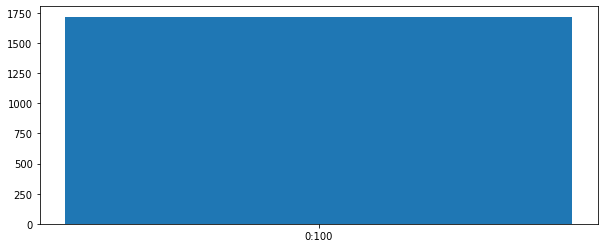

In [ ]:
token_len_sort = sorted({i:j for i, j in zip(train_df['token_len_cate'].value_counts().keys(), train_df['token_len_cate'].value_counts().values)}.items(), key=lambda x:x[0])
x = [i for (i,_) in token_len_sort]
y = [i for (_,i) in token_len_sort]
print(y)

plt.figure(figsize=(10, 4))
plt.bar(x, y)
plt.show()

In [ ]:
train_df.describe()

,token_len
count,1718.000000
mean,34.850407
std,24.111764
min,1.000000
25%,14.000000
50%,28.000000
75%,57.000000
max,96.000000


## Data split

In [ ]:
filtering_train_df = train_df.copy()

In [ ]:
cut = round(len(filtering_train_df) * 0.8)
filtering_train_df, filtering_test_df = filtering_train_df[:cut], filtering_train_df[cut:]

In [ ]:
filtering_test_df = filtering_test_df.reset_index(drop=True)

In [ ]:
print(len(filtering_train_df))
len(filtering_test_df)

1374


344

## 학습을 위해 토큰으로 자르기

In [ ]:
filtering_train_df['split_train_token'] = [tok(i.strip()) for i in filtering_train_df['train']]
filtering_train_df['split_label_token'] = [tok(i.strip()) for i in filtering_train_df['label']]
filtering_train_df['split_train_token'] = filtering_train_df['split_train_token'].apply(lambda x: ' '.join(map(str, x)))
filtering_train_df['split_label_token'] = filtering_train_df['split_label_token'].apply(lambda x: ' '.join(map(str, x)))
filtering_train_df['split_train_token'] = ['<esp> ' + i.strip().replace('&&', ' <esp> ') + ' <esp>' for i in filtering_train_df['split_train_token']]
filtering_train_df['split_label_token'] = ['<esp> ' + i.strip() + ' <esp>' for i in filtering_train_df['split_label_token']]

In [ ]:
filtering_train_df.head()

,train,label,token_len,token_len_cate,split_train_token,split_label_token
0,청송주왕산보문꿀사과,청송주왕산고랭지꿀사과,6,0:100,<esp> 청송 주왕산 보문 꾸 ㄹ 사과 <esp>,<esp> 청송 주왕산 고랭지 꿀 사과 <esp>
1,무안 자색양파즙 180포&&[아침에떡] 당일생산 뜨끈뜨끈 입술 기정떡 3종 中 택1...,[유기농] 당찬여주즙60ml * 30포 * 8박스,45,0:100,<esp> 무안 자색 양파 즙 180 포 <esp> [ 아침 에 떡 ] 당일 생...,<esp> [ 유기농 ] 당차 ㄴ 여주 즙 60 ml * 30 포 * 8 박스 <esp>
2,[게릴라] [귤로장생]하우스 밀감(3kg)&&강원도 햇 미백찰옥수수 51개&&[비타...,[한일스텐레스] 프리미엄 통5중 인덕션 스텐냄비 모음전,58,0:100,<esp> [ 게릴라 ] [ 귤 로 장생 ] 하우스 밀감 ( 3 kg ) <esp...,<esp> [ 하 ㄴ 일 스텐레스 ] 프리미엄 통 5 중 인덕 션 스텐 냄비 모음 ...
3,[게릴라]모닝애플 주스 120ml * 60포&&[발레리]라이크라런닝형브라팬티10종_...,[맛있는김치]도미솔 왕비포기김치 11kg,68,0:100,<esp> [ 게릴라 ] 모닝 애플 주스 120 ml * 60 포 <esp> [...,<esp> [ 맛있 는 김치 ] 도미 솔 왕비 포기김치 11 kg <esp>
4,이비인후과/진료비&&약제비&&감염내과/진료비&&약제비,호흡기내과/진료비,14,0:100,<esp> 이비인후과 / 진료비 <esp> 약제 비 <esp> 감염 내과 /...,<esp> 호흡기 내과 / 진료비 <esp>


In [ ]:
MAX_LENGTH = 128

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(filtering_train_df['split_train_token'] + filtering_train_df['split_label_token'], target_vocab_size=2**13)

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [4486]
종료 토큰 번호 : [4487]
단어 집합의 크기 : 4488


In [ ]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
train_token, label_token = tokenize_and_filter(filtering_train_df['split_train_token'], filtering_train_df['split_label_token'])

In [ ]:
print('질문 데이터의 크기(shape) :', train_token.shape)
print('답변 데이터의 크기(shape) :', label_token.shape)

질문 데이터의 크기(shape) : (1374, 128)
답변 데이터의 크기(shape) : (1374, 128)


## GPU 작동 확인

In [ ]:
tf.test.is_gpu_available()

True

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Mon Apr 19 12:24:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   2218MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 학습

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_token,
        'dec_inputs': label_token[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': label_token[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# NUM_LAYERS = 2
NUM_LAYERS = 1
D_MODEL = 128
NUM_HEADS = 4
UNITS = 256
DROPOUT = 0.2


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 250

In [ ]:
model.summary()

In [ ]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/250
6/6 [==============================] - 6s 322ms/step - loss: 1.1527 - accuracy: 3.2673e-05
Epoch 2/250
6/6 [==============================] - 2s 316ms/step - loss: 1.1489 - accuracy: 4.4594e-05
Epoch 3/250
6/6 [==============================] - 2s 314ms/step - loss: 1.1415 - accuracy: 6.7668e-05
Epoch 4/250
6/6 [==============================] - 2s 316ms/step - loss: 1.1514 - accuracy: 1.1372e-04
Epoch 5/250
6/6 [==============================] - 2s 317ms/step - loss: 1.1378 - accuracy: 1.7569e-04
Epoch 6/250
6/6 [==============================] - 2s 316ms/step - loss: 1.1577 - accuracy: 2.1275e-04
Epoch 7/250
6/6 [==============================] - 2s 316ms/step - loss: 1.1321 - accuracy: 3.3007e-04
Epoch 8/250
6/6 [==============================] - 2s 317ms/step - loss: 1.1452 - accuracy: 6.0363e-04
Epoch 9/250
6/6 [==============================] - 2s 315ms/step - loss: 1.1360 - accuracy: 0.0011
Epoch 10/250
6/6 [==============================] - 2s 314ms/step - loss: 1.1

In [ ]:
# model.save_weights(path+f'Transformer_kr_{EPOCHS}_layers_{NUM_LAYERS}.ckpt')

In [ ]:
# model.load_weights(path+f'Transformer_kr_{EPOCHS}_layers_{NUM_LAYERS}.ckpt')

## 검증

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

#   print('Input: {}'.format(sentence))
#   print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
predict(filtering_train_df['split_train_token'][2])

'<esp> [ 하 ㄴ 일 스텐레스 ] 프리미엄 통 5 중 인덕 션 스텐 냄비 모음 전 <esp>'

In [ ]:
filtering_test_df['split_train_token'] = [tok(i.strip()) for i in filtering_test_df['train']]
filtering_test_df['split_label_token'] = [tok(i.strip()) for i in filtering_test_df['label']]
filtering_test_df['split_train_token'] = filtering_test_df['split_train_token'].apply(lambda x: ' '.join(map(str, x)))
filtering_test_df['split_label_token'] = filtering_test_df['split_label_token'].apply(lambda x: ' '.join(map(str, x)))
filtering_test_df['split_train_token'] = ['<esp> ' + i.strip().replace('&&', ' <esp> ') + ' <esp>' for i in filtering_test_df['split_train_token']]
filtering_test_df['split_label_token'] = ['<esp> ' + i.strip() + ' <esp>' for i in filtering_test_df['split_label_token']]

In [ ]:
filtering_test_df.pop('token_len')
filtering_test_df.pop('token_len_cate')
filtering_test_df.head()

,train,label,token_len,token_len_cate,split_train_token,split_label_token
0,우편물,보령삼육조미구이식탁김,1,0:100,<esp> 우편물 <esp>,<esp> 보령 삼육 조미 구이 식탁 김 <esp>
1,"[팝핀 도너츠] 도넛 6종세트 15개/30개(바바리안, 딸기, 보스톤 메론 , 땅콩...",★지난 총 8회 매진 신화★서산 간월도식 어리굴젓8통 + 양념굴젓4통,86,0:100,<esp> [ 팝 핀 도너츠 ] 도넛 6 종 세트 15 개 / 30 개 ( 바바리 ...,<esp> ★ 지나 ㄴ 총 8 회 매진 신화 ★ 서산 간월 도식 어리 굴젓 8 통 ...
2,양구 펀치볼 시래기17팩+맛내기17팩,[상시]강원도명물더덕무침(13팩),13,0:100,<esp> 양 구 펀치 보 ㄹ 시래기 17 팩 + 맛 내기 17 팩 <esp>,<esp> [ 상시 ] 강원도 명물 더덕 무침 ( 13 팩 ) <esp>
3,류마티스내과/진료비&&약제비&&약제비&&심장내과/진료비,이비인후과/진료비,16,0:100,<esp> 류 마티스 내과 / 진료비 <esp> 약제 비 <esp> 약제 비...,<esp> 이비인후과 / 진료비 <esp>
4,여수 거문도 해풍쑥 생개떡 2kg&&깊고 진한 전라도 김치 2kg 포장/한정판매 갓...,특산영농조합법인곶감(반건시),59,0:100,<esp> 여수 거문도 해풍 쑥 생 개떡 2 kg <esp> 깊 고 진하 ㄴ 전...,<esp> 특산 영농 조합 법인 곶감 ( 반 건시 ) <esp>


In [ ]:
tqdm.tqdm.pandas()
predict_item_test = filtering_test_df['split_train_token'].progress_apply(predict)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 344/344 [04:11<00:00,  1.37it/s]


In [ ]:
filtering_test_df['predict_item'] = predict_item_test

False    204
True     140
dtype: int64

In [ ]:
filtering_test_df

,train,label,token_len,token_len_cate,split_train_token,split_label_token,predict_item
0,우편물,보령삼육조미구이식탁김,1,0:100,<esp> 우편물 <esp>,<esp> 보령 삼육 조미 구이 식탁 김 <esp>,<esp> 우편물 <esp>
1,"[팝핀 도너츠] 도넛 6종세트 15개/30개(바바리안, 딸기, 보스톤 메론 , 땅콩...",★지난 총 8회 매진 신화★서산 간월도식 어리굴젓8통 + 양념굴젓4통,86,0:100,<esp> [ 팝 핀 도너츠 ] 도넛 6 종 세트 15 개 / 30 개 ( 바바리 ...,<esp> ★ 지나 ㄴ 총 8 회 매진 신화 ★ 서산 간월 도식 어리 굴젓 8 통 ...,<esp> 국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.5 kg ) <esp>
2,양구 펀치볼 시래기17팩+맛내기17팩,[상시]강원도명물더덕무침(13팩),13,0:100,<esp> 양 구 펀치 보 ㄹ 시래기 17 팩 + 맛 내기 17 팩 <esp>,<esp> [ 상시 ] 강원도 명물 더덕 무침 ( 13 팩 ) <esp>,<esp> 쫄깃 담백 참숯 굽 ㄴ 계란 60 구 <esp>
3,류마티스내과/진료비&&약제비&&약제비&&심장내과/진료비,이비인후과/진료비,16,0:100,<esp> 류 마티스 내과 / 진료비 <esp> 약제 비 <esp> 약제 비...,<esp> 이비인후과 / 진료비 <esp>,<esp> 약제 비 <esp>
4,여수 거문도 해풍쑥 생개떡 2kg&&깊고 진한 전라도 김치 2kg 포장/한정판매 갓...,특산영농조합법인곶감(반건시),59,0:100,<esp> 여수 거문도 해풍 쑥 생 개떡 2 kg <esp> 깊 고 진하 ㄴ 전...,<esp> 특산 영농 조합 법인 곶감 ( 반 건시 ) <esp>,<esp> 영광 법성포 굴비 마을 굴비 <esp>
...,...,...,...,...,...,...,...
339,고기랑 찰떡궁합! 청도 미나리 500g&&[명절특가] 황제의아침 숙성흑마늘진액 10...,[횡성명품한우] 횡성 한우 정육 4호 선물세트(불불국),74,0:100,<esp> 고기 랑 찰떡 궁합 ! 청도 미나리 500 g <esp> [ 명절 특...,<esp> [ 횡 성명 품 하 ㄴ 우 ] 횡 성 한우 정육 4 호 선물세트 ( 불 ...,<esp> 2021 년 설명 절 ] 부침 명장 명절 모둠 전 \&undsc 3 <esp>
340,귤로장생 제주 햇 레드향 1.8kg*3박스&& 미루 구수한 누룽지 3종세트(50봉),★초특가★[게릴라]옛날 쥐치포,27,0:100,<esp> 귤 로 장생 제주 하 였 레드 향 1.8 kg * 3 박스 <esp> ...,<esp> ★ 초 특가 ★ [ 게릴라 ] 옛날 쥐치 포 <esp>,"<esp> 신 강식 아트 컬러 레이스 집 업 상 , 하세 트 <esp>"
341,평창애 양념코다리180g,영광법성포이조굴비,6,0:100,<esp> 평 창애 양념 코다리 180 g <esp>,<esp> 영광 법성포 이조 굴비 <esp>,<esp> 통영 유기농 키위 참 다래 2 kg <esp>
342,미납통행료,미납통행료,2,0:100,<esp> 미납 통행료 <esp>,<esp> 미납 통행료 <esp>,<esp> 미납 통행료 <esp>


# Product2Vec

In [ ]:
TFoutputs = filtering_test_df

In [ ]:
Detail = pd.DataFrame(detail)

In [ ]:
Detail['tok'] = [tok(i.strip()) for i in Detail['0']]
Detail['tok'] = Detail['tok'].apply(lambda x: ' '.join(map(str, x)))
detail_esp = ['<esp> ' + i + ' <esp>' for i in Detail['tok']]
Detail['esp'] = detail_esp
detail_esp[:5]

In [ ]:
detail_esp = Detail['esp'].to_list()
detail_esp[:5]

['<esp> Americano / Tall 외 1 건 <esp>',
 '<esp> Americano / Tall 외 2 건 <esp>',
 '<esp> Caffe Mocha / Tall 외 1 건 <esp>',
 '<esp> Orange juice / Tall <esp>',
 '<esp> 김 가 네 김밥 <esp>']

In [ ]:
Detail.head()

In [ ]:
dic = {Detail['tok'][i]:Detail['0'][i] for i in range(len(Detail))}

{'Americano / Tall 외 1 건': 'Americano / Tall외 1건',
 'Americano / Tall 외 2 건': 'Americano / Tall외 2건',
 'Caffe Mocha / Tall 외 1 건': 'Caffe Mocha / Tall외 1건',
 'Orange juice / Tall': 'Orange juice / Tall',
 '김 가 네 김밥': '김가네김밥',
 '리얼 초 코 자바 칩 프라페 / 휘 핑 반 만 올리 기 외 1 건': '리얼초코자바칩프라페 / 휘핑 반만올리기외 1건',
 '( 기본 ) 비빔 국수': '(기본) 비빔국수',
 '소 불고기 김밥': '소불고기김밥',
 'Signature Chocolate / Tall 외 1 건': 'Signature Chocolate / Tall외 1건',
 'Caffe latte / Tall 외 1 건': 'Caffe latte / Tall외 1건',
 '( 小 ) 로스 팅 훈제 족발 + 쟁반 국수': '(小) 로스팅훈제족발+쟁반국수',
 '무료 배달': '무료배달',
 '( 2 마리 ) 코다리 매콤 명태 찜 / 젓가락 빼주 세 요외 2 건': '(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건',
 '아메리카 노 / HOT': '아메리카노 / HOT',
 '크로 와플': '크로와플',
 '아메리카 노 / HOT 외 5 건': '아메리카노 / HOT외 5건',
 '아메리카 노 / HOT 외 7 건': '아메리카노 / HOT외 7건',
 '아메리카 노 / ICE 외 7 건': '아메리카노 / ICE외 7건',
 '모듬 전': '모듬전',
 '일벌 세트 / 약간 덜 매운맛 : 추천 맵 기 ( 20 % ) 외 2 건': '일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건',
 '크로 와플 ( NEW )': '크로와플 (NEW)',
 '아메리카 노 / ICE': '아메리카노 / ICE',
 '( 2 p ) 플레인 크로플 / 포크 만 주 세요': '(2p) 플레인크로플 / 

In [ ]:
checker = pd.Series([i in detail_esp for i in TFoutputs['predict_item']])
print(checker.value_counts())
filter = checker[checker == False].index
len(filter)

True     272
False     72
dtype: int64


72

In [ ]:
TFoutputs['filter'] = checker
TFoutputs

,train,label,token_len,token_len_cate,split_train_token,split_label_token,predict_item,filter
0,우편물,보령삼육조미구이식탁김,1,0:100,<esp> 우편물 <esp>,<esp> 보령 삼육 조미 구이 식탁 김 <esp>,<esp> 우편물 <esp>,True
1,"[팝핀 도너츠] 도넛 6종세트 15개/30개(바바리안, 딸기, 보스톤 메론 , 땅콩...",★지난 총 8회 매진 신화★서산 간월도식 어리굴젓8통 + 양념굴젓4통,86,0:100,<esp> [ 팝 핀 도너츠 ] 도넛 6 종 세트 15 개 / 30 개 ( 바바리 ...,<esp> ★ 지나 ㄴ 총 8 회 매진 신화 ★ 서산 간월 도식 어리 굴젓 8 통 ...,<esp> 국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.5 kg ) <esp>,False
2,양구 펀치볼 시래기17팩+맛내기17팩,[상시]강원도명물더덕무침(13팩),13,0:100,<esp> 양 구 펀치 보 ㄹ 시래기 17 팩 + 맛 내기 17 팩 <esp>,<esp> [ 상시 ] 강원도 명물 더덕 무침 ( 13 팩 ) <esp>,<esp> 쫄깃 담백 참숯 굽 ㄴ 계란 60 구 <esp>,True
3,류마티스내과/진료비&&약제비&&약제비&&심장내과/진료비,이비인후과/진료비,16,0:100,<esp> 류 마티스 내과 / 진료비 <esp> 약제 비 <esp> 약제 비...,<esp> 이비인후과 / 진료비 <esp>,<esp> 약제 비 <esp>,True
4,여수 거문도 해풍쑥 생개떡 2kg&&깊고 진한 전라도 김치 2kg 포장/한정판매 갓...,특산영농조합법인곶감(반건시),59,0:100,<esp> 여수 거문도 해풍 쑥 생 개떡 2 kg <esp> 깊 고 진하 ㄴ 전...,<esp> 특산 영농 조합 법인 곶감 ( 반 건시 ) <esp>,<esp> 영광 법성포 굴비 마을 굴비 <esp>,True
...,...,...,...,...,...,...,...,...
339,고기랑 찰떡궁합! 청도 미나리 500g&&[명절특가] 황제의아침 숙성흑마늘진액 10...,[횡성명품한우] 횡성 한우 정육 4호 선물세트(불불국),74,0:100,<esp> 고기 랑 찰떡 궁합 ! 청도 미나리 500 g <esp> [ 명절 특...,<esp> [ 횡 성명 품 하 ㄴ 우 ] 횡 성 한우 정육 4 호 선물세트 ( 불 ...,<esp> 2021 년 설명 절 ] 부침 명장 명절 모둠 전 \&undsc 3 <esp>,False
340,귤로장생 제주 햇 레드향 1.8kg*3박스&& 미루 구수한 누룽지 3종세트(50봉),★초특가★[게릴라]옛날 쥐치포,27,0:100,<esp> 귤 로 장생 제주 하 였 레드 향 1.8 kg * 3 박스 <esp> ...,<esp> ★ 초 특가 ★ [ 게릴라 ] 옛날 쥐치 포 <esp>,"<esp> 신 강식 아트 컬러 레이스 집 업 상 , 하세 트 <esp>",True
341,평창애 양념코다리180g,영광법성포이조굴비,6,0:100,<esp> 평 창애 양념 코다리 180 g <esp>,<esp> 영광 법성포 이조 굴비 <esp>,<esp> 통영 유기농 키위 참 다래 2 kg <esp>,True
342,미납통행료,미납통행료,2,0:100,<esp> 미납 통행료 <esp>,<esp> 미납 통행료 <esp>,<esp> 미납 통행료 <esp>,True


In [ ]:
pred = TFoutputs['predict_item']
pred = pred.str.replace('<esp>', '')
pred = pred.str.strip()
pred.head()

0                                    우편물
1    국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.5 kg )
2                   쫄깃 담백 참숯 굽 ㄴ 계란 60 구
3                                   약제 비
4                        영광 법성포 굴비 마을 굴비
Name: predict_item, dtype: object

In [ ]:
falses = pd.Series([TFoutputs['predict_item'][i] for i in filter])
falses = falses.str.replace('<esp>', '')
falses = falses.str.strip()
print(len(falses))
falses.head()

72


0                  국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.5 kg )
1                                                 참 멸치
2    [ 명절 특가 ] 황제 의 아침 숙성 흑 마늘 진액 1000 1 L 1 병 ( 11...
3           2020 농협 천생 연 세척 사과 3 kg * 3 박스 + 천혜 향 3 박스
4    [ 1 / 22 단 하루 ] [ 공 영 X 강 블 ㄹ 리 ] 스킨 케어 인기 제품 ...
dtype: object

In [ ]:
user2item = ds_customer.copy()

In [ ]:
user2item.columns = ['유저 식별키', '유저 구매 상품 식별키 묶음']
user2item

,유저 식별키,유저 구매 상품 식별키 묶음
0,36,우편물&&더블더블 / 감자튀김 딥치즈 업그레이드 세트&&꿀유자차 / 아이스&&바닐라...
1,17492,납기내금액&&납기내금액&&납기내금액&&납기내금액&&납기내금액&&납기내금액&&납기내금...
2,26661,무료배달&&무료배달&&베이컨 치즈버거 / 일반세트(버거+음료+감자튀김)&&무료배달&...
3,27462,"컬쳐캐쉬1건&&컬쳐캐쉬1건&&아메리카노(일반) / 아이스,킹&&떡볶이&&더블더블 /..."
4,27478,납기내금액&&납기내금액&&임성근손질민물장어 12팩+소스10봉&&납기내금액&&아메리카...
...,...,...
3407,1987446,일벌세트 / 약간 덜매운맛 : 추천 맵기(20%)외 2건&&일벌세트 / 약간 덜매운...
3408,1987625,(2마리) 코다리매콤명태찜 / 젓가락빼주세요외 2건&&(2마리) 코다리매콤명태찜 /...
3409,1987728,리얼초코자바칩프라페 / 휘핑 반만올리기외 1건&&아메리카노 / HOT&&아메리카노 ...
3410,1996381,[Best] 제주 흑돼지 돈까스샌드위치&&[Bset] 프레즐빠다


## Product2Vector 생성

### Jaccard 유사도

In [ ]:
def JaccardSimilarity(inp1, inp2):
    list_inp1 = inp1.split()
    list_inp2 = inp2.split()
    mom = set(list_inp1).union(set(list_inp2))
    son = set(list_inp1).intersection(set(list_inp2))
    # print(mom)
    # print(son)
    return len(son)/len(mom)

In [ ]:
detail = Detail['tok'].unique()

In [ ]:
pd.Series([i in detail for i in pred]).value_counts()

True     272
False     72
dtype: int64

In [ ]:
asdf = []

for v in falses:
    max = 0
    for d in detail:
        score = JaccardSimilarity(v, d)
        if max < score:
            max = score
            temp = d
    if max == 0: asdf.append(v)
    id = pred[pred == v].index
    for i in id:
        pred[i] = temp

len(asdf)

0

In [ ]:
pd.Series([i in detail for i in pred]).value_counts()

True    344
dtype: int64

In [ ]:
changes = pd.DataFrame(columns=['Original', 'Changed'])
changes['Original'] = falses
changes['Changed'] = pred[filter].to_list()
changes

,Original,Changed
0,국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.5 kg ),국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.1 kg )
1,참 멸치,통영 참 멸치
2,[ 명절 특가 ] 황제 의 아침 숙성 흑 마늘 진액 1000 1 L 1 병 ( 11...,[ 명절 특가 ] 황제 의 아침 숙성 흑 마늘 진액 1000 1 L 1 병 + 쇼핑...
3,2020 농협 천생 연 세척 사과 3 kg * 3 박스 + 천혜 향 3 박스,농협 세척 사과 3 kg * 2 박스 + 천혜 향 2 kg
4,[ 1 / 22 단 하루 ] [ 공 영 X 강 블 ㄹ 리 ] 스킨 케어 인기 제품 ...,[ 1 / 22 단 하루 ] [ 공 영 X 강 블 ㄹ 리 ] 스킨 케어 인기 제품 ...
...,...,...
67,[ 게릴라 ] 창화 당 만두 세트 8 팩 ( 고기 참 3.4 kg ),"[ 게릴라 ] 창화 당 만두 세트 8 팩 ( 고기 참 3 , 김치 참 3 , 납작 ..."
68,[ 일시불 ] 유기농 당 찬 여주 즙 60 ml * 30 포,[ 일시불 ] 유기농 당 찬 여주 즙 60 ml * 30 포 * 8 박스
69,목우 촌 순 사 ㄹ 닭다리 사 ㄹ 구이 2 종 세트,목우 촌 순 사 ㄹ 닭다리 사 ㄹ 구이 2 종 세트 ( 110 * 16 팩 )
70,2021 년 설명 절 ] 부침 명장 명절 모둠 전 \&undsc 3,[ 2021 년 설명 절 ] 부침 명장 명절 모둠 전 _ 9 팩


### 토큰-상품명 변환

In [ ]:
display(pred)
for i in range(len(pred)):
    pred[i] = dic.get(pred[i])
pred

0                                                    우편물
1                    국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.1 kg )
2                                   쫄깃 담백 참숯 굽 ㄴ 계란 60 구
3                                                   약제 비
4                                        영광 법성포 굴비 마을 굴비
                             ...                        
339                  [ 2021 년 설명 절 ] 부침 명장 명절 모둠 전 _ 9 팩
340                          신 강식 아트 컬러 레이스 집 업 상 , 하세 트
341                                  통영 유기농 키위 참 다래 2 kg
342                                               미납 통행료
343    [ 명절 특가 ] 황제 의 아침 숙성 흑 마늘 진액 1000 1 L 1 병 + 쇼핑...
Name: predict_item, Length: 344, dtype: object

0                                          우편물
1                      국내산대패삼겹살300g*7팩(총2.1kg)
2                             쫄깃담백 참숯 구운계란 60구
3                                          약제비
4                                  영광법성포굴비마을굴비
                        ...                   
339                   [2021년 설명절]부침명장 명절모둠전_9팩
340                      신강식 아트컬러 레이스 집업 상,하세트
341                           통영 유기농키위 참다래 2kg
342                                      미납통행료
343    [명절특가] 황제의아침 숙성흑마늘진액 1000 1L 1병+ 쇼핑백 1장
Name: predict_item, Length: 344, dtype: object

### Word2vec Model 학습

In [ ]:
model = Word2Vec([item_list.split('&&') for item_list in user2item['유저 구매 상품 식별키 묶음']], size=100, window=5, min_count=1, negative=15, iter=20, sample=0.00001, sg=1)

In [ ]:
# 유저 성향 벡터 구하기 
user_propensity_vector = []
for item_list in tqdm_notebook(user2item['유저 구매 상품 식별키 묶음']):
    item_list = item_list.split('&&')
    bbb = np.array(np.ones(100))
    for aaa in item_list:
        bbb *= model[aaa]
        bbb = bbb/norm(bbb)
    user_propensity_vector.append(bbb)

In [ ]:
# 유사 product 찾기
# def find_item(user, n=10):
#     item_code = user2item[user2item['유저 식별키']==user]['유저 구매 상품 식별키 묶음'].values[0].split('&&')[-1]
#     return list(dict(model.wv.most_similar(item_code, topn=n)))

def find_item(item, n=10):
    return list(dict(model.wv.most_similar(item, topn=n)))

# 유저 유사도 계산 및 유사 유저 찾기
def user_sim(A, B): 
    A_vec = user_propensity_vector[user2item[user2item['유저 식별키']==A].index[0]]
    B_vec = user_propensity_vector[user2item[user2item['유저 식별키']==B].index[0]]
    return euclidean(A_vec.reshape(-1, 1), B_vec.reshape(-1, 1))

def find_user(user):
    user_index = user2item[user2item['유저 식별키']==user].index[0]
    min_user_similar = min(user_matrix_f[user_index].drop(user_index))
    return user2item.iloc[{j:i for i, j in enumerate(user_matrix_f[user_index])}[min_user_similar]]['유저 식별키']

In [ ]:
# # 유저 유사도 매트릭스
# user_matrix_f = pd.DataFrame()
# for i in tqdm_notebook(range(len(user_propensity_vector))):
#     tmp = []
#     for j in range(len(user_propensity_vector)):
#         tmp.append(euclidean(user_propensity_vector[i], user_propensity_vector[j]))
#     user_matrix_f = pd.concat([user_matrix_f, pd.DataFrame(tmp)], axis = 1)
# user_matrix_f.columns = user_matrix_f.index
# user_matrix_f

In [ ]:
pred[0]

'우편물'

In [ ]:
find_item(pred[0])

['[월드컵]여성 썸머 다이얼 트레킹화 세트',
 '2019수확 [자연향/미얀마단일품종] 세척사과 3kg*3박스 / 총9kg',
 '(EX)ICED 카페 라떼',
 '[개국초특가]도미솔 왕비포기김치 12kg',
 '■Premium 명장김치 11kg■김순자명장 포기6kg+총각김치3kg+열무김치2kg',
 '[오롯담] 양념찜갈비500g×6팩',
 '안동인 안동찜닭세트 4인분외 3개',
 '★초복전배송가능★우렁추어탕 12팩 ',
 '(제주직배송)레드향+천혜향 (혼합과) 선물용 5kg(20-25과)',
 '[20년산] 포근포근 햇 감자 3kg/5kg']

## 구매전 : Top-10 시나리오

In [ ]:
def recommend(n=10, acc=False, pred=pred, TFoutputs=TFoutputs):
    item_list = []
    for v in tqdm_notebook(pred.to_list()):
        if n > 1:
            pp = find_item(v, n-1)
            pp.insert(0, v)
            item_list.append(pp)
        else: item_list.append(v)
    TFoutputs['추천 list'] = item_list
    TFoutputs['정답 유무'] = [True if label in item else False for label, item in tqdm_notebook(zip(TFoutputs['label'], TFoutputs['추천 list']), total=(len(TFoutputs)))]
    # 추천 알고리듬 구매전 Top-10 성능평가
    
    if acc:
        return TFoutputs[TFoutputs['정답 유무']==True].shape[0]/(TFoutputs.shape[0])

    return TFoutputs

In [ ]:
recommend(n=5, acc=True)

0.14825581395348839

In [ ]:
recommend(n=10, acc=True)

0.15988372093023256

In [ ]:
recommend(n=20, acc=True)

0.1686046511627907

In [ ]:
recommend()

,train,label,token_len,token_len_cate,split_train_token,split_label_token,predict_item,filter,추천 list,정답 유무
0,우편물,보령삼육조미구이식탁김,1,0:100,<esp> 우편물 <esp>,<esp> 보령 삼육 조미 구이 식탁 김 <esp>,<esp> 우편물 <esp>,True,"[[월드컵]여성 썸머 다이얼 트레킹화 세트, 2019수확 [자연향/미얀마단일품종] ...",False
1,"[팝핀 도너츠] 도넛 6종세트 15개/30개(바바리안, 딸기, 보스톤 메론 , 땅콩...",★지난 총 8회 매진 신화★서산 간월도식 어리굴젓8통 + 양념굴젓4통,86,0:100,<esp> [ 팝 핀 도너츠 ] 도넛 6 종 세트 15 개 / 30 개 ( 바바리 ...,<esp> ★ 지나 ㄴ 총 8 회 매진 신화 ★ 서산 간월 도식 어리 굴젓 8 통 ...,<esp> 국내산 대패 삼겹살 300 g * 7 팩 ( 총 2.5 kg ) <esp>,False,"[대천김, 키친아트 스텐밀폐용기 18종, 2020 농협 햇복숭아(3kg*2박스)_백...",False
2,양구 펀치볼 시래기17팩+맛내기17팩,[상시]강원도명물더덕무침(13팩),13,0:100,<esp> 양 구 펀치 보 ㄹ 시래기 17 팩 + 맛 내기 17 팩 <esp>,<esp> [ 상시 ] 강원도 명물 더덕 무침 ( 13 팩 ) <esp>,<esp> 쫄깃 담백 참숯 굽 ㄴ 계란 60 구 <esp>,True,"[[개국5주년 게릴라] 파뷔에항균도마세트 총 3종, 김규흔명장의 실속 한과 세트 (...",False
3,류마티스내과/진료비&&약제비&&약제비&&심장내과/진료비,이비인후과/진료비,16,0:100,<esp> 류 마티스 내과 / 진료비 <esp> 약제 비 <esp> 약제 비...,<esp> 이비인후과 / 진료비 <esp>,<esp> 약제 비 <esp>,True,"[사임당 떡 4종 세트(총 110알), 소닉케어 프로리절트 칫솔모 HX6014/63...",False
4,여수 거문도 해풍쑥 생개떡 2kg&&깊고 진한 전라도 김치 2kg 포장/한정판매 갓...,특산영농조합법인곶감(반건시),59,0:100,<esp> 여수 거문도 해풍 쑥 생 개떡 2 kg <esp> 깊 고 진하 ㄴ 전...,<esp> 특산 영농 조합 법인 곶감 ( 반 건시 ) <esp>,<esp> 영광 법성포 굴비 마을 굴비 <esp>,True,"[[수협]자연산 손질 촉촉오징어_대사이즈 총20미 , 황 매실액 매실청 3년숙성 ...",False
...,...,...,...,...,...,...,...,...,...,...
339,고기랑 찰떡궁합! 청도 미나리 500g&&[명절특가] 황제의아침 숙성흑마늘진액 10...,[횡성명품한우] 횡성 한우 정육 4호 선물세트(불불국),74,0:100,<esp> 고기 랑 찰떡 궁합 ! 청도 미나리 500 g <esp> [ 명절 특...,<esp> [ 횡 성명 품 하 ㄴ 우 ] 횡 성 한우 정육 4 호 선물세트 ( 불 ...,<esp> 2021 년 설명 절 ] 부침 명장 명절 모둠 전 \&undsc 3 <esp>,False,"[[5주년기념 초특가] 김연도 오색현미 21봉, ■Premium 명장김치 11kg■...",False
340,귤로장생 제주 햇 레드향 1.8kg*3박스&& 미루 구수한 누룽지 3종세트(50봉),★초특가★[게릴라]옛날 쥐치포,27,0:100,<esp> 귤 로 장생 제주 하 였 레드 향 1.8 kg * 3 박스 <esp> ...,<esp> ★ 초 특가 ★ [ 게릴라 ] 옛날 쥐치 포 <esp>,"<esp> 신 강식 아트 컬러 레이스 집 업 상 , 하세 트 <esp>",True,"[ 산소계 표백제 과탄산소다 대용량 5kg , ★2020 햇!★ 홍천 미니 밤단호박...",False
341,평창애 양념코다리180g,영광법성포이조굴비,6,0:100,<esp> 평 창애 양념 코다리 180 g <esp>,<esp> 영광 법성포 이조 굴비 <esp>,<esp> 통영 유기농 키위 참 다래 2 kg <esp>,True,"[앙큼플라워떡케이크 1호, [월드컵]여성 썸머 다이얼 트레킹화 세트, 고당도 서귀포...",False
342,미납통행료,미납통행료,2,0:100,<esp> 미납 통행료 <esp>,<esp> 미납 통행료 <esp>,<esp> 미납 통행료 <esp>,True,"[함평천지 승현이네 새싹삼 랜덤 50뿌리, 무주장터 안성들풀 찹쌀 4kg, 노랑 호...",True
